In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re

In [ ]:
# Load the data, and print the first few rows to see what it looks like
df_video = pd.read_json('./yt_metadata_filtered.jsonl', lines=True)
print(df_video.head())

  categories                channel_id                  crawl_date  \
0     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.001044   
1     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:33.563584   
2     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.350067   
3     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:36.930863   
4     Gaming  UCzWm1-4XF7AHxVUTkHCM1uw  2019-11-17 06:28:39.777410   

  description  dislike_count   display_id  duration  like_count  \
0                        6.0  iWbFNJaaHrw       270        47.0   
1                        8.0  MRaGK43Ux-k       109        52.0   
2                        4.0  -91qrjpgRw0        58        26.0   
3                        8.0  nq9_WZXjjCI        71        25.0   
4                       24.0  Kh-s-TEnqWY      7508        43.0   

                                                tags  \
0  video,games,retrogamer3,ed,findlay,Trump,Ameri...   
1  video,games,retrogamer3,ed,findlay,America's R...   
2  video

In [ ]:
# List of keywords corresponding to conspiracy theories
conspiracy_keywords = {
    "Deep State": ["deepstate", "deep state", "government faction", "shadow government", "hidden government"],
    "Election Fraud": ["election fraud", "vote fraud", "mail-in ballots", "voter suppression", "rigged election"],
    "QAnon": ["qanon", "cabal", "child trafficking", "satanic rituals", "deep-rooted cabal", "Q movement"],
    "Missing Emails": ["missing emails", "deleted emails", "clinton emails", "email scandal", "email leak"],
    "Biden Family Scandal": ["biden family scandal", "hunter biden", "biden corruption", "biden business dealings", "biden influence"],
    "Climate Change Hoax": ["climate change hoax", "global elites", "climate profit", "false climate", "climate deception"]
}

# Check if a text contains any of the conspiracy theories
def detect_conspiracy_types(row, keywords_dict):
    # Combine relevant text fields
    text = ' '.join([str(row['title']), str(row['description']), str(row['tags'])]).lower()
    for theory, keywords in keywords_dict.items():
        # Use regular expressions for matching
        pattern = re.compile('|'.join([re.escape(word) for word in keywords]), re.IGNORECASE)
        if pattern.search(text):
            return True
    return False

# Create a mask that selects rows where the title, description, or tags contain any of the keywords
df_video.fillna({'title': '', 'description': '', 'tags': ''}, inplace=True)
mask = df_video.apply(lambda row: detect_conspiracy_types(row, conspiracy_keywords), axis=1)

# Apply the mask to the data
filtered_data = df_video[mask]
print(filtered_data.shape)
print(filtered_data.head())

(9084, 13)
          categories                channel_id                  crawl_date  \
412           Comedy  UCzS3-65Y91JhOxFiM7j6grg  2019-11-14 21:04:52.331908   
416           Comedy  UCzS3-65Y91JhOxFiM7j6grg  2019-11-14 21:04:21.040382   
565  News & Politics  UCzOnXvfwc32YEiwTe_8Nf-g  2019-11-02 02:36:54.989605   
689  News & Politics  UCzFSNq-Q7QV6kBSw9zCoVXg  2019-11-02 13:42:35.959962   
690  News & Politics  UCzFSNq-Q7QV6kBSw9zCoVXg  2019-11-02 13:42:36.677387   

    description  dislike_count   display_id  duration  like_count  \
412                    22808.0  xrkPe-9rM1Q       347    256974.0   
416                      102.0  g6uhAdnWHaA       195       341.0   
565                       18.0  2KYpsGwM8bI      4830       228.0   
689                      117.0  63N5FOYeD2U      1968     20290.0   
690                      143.0  tnRDLjULtOE      2338     20045.0   

                                                  tags  \
412  funnyordie,funny or die,funny,comedy,sketc

In [4]:
# Save the filtered data as a JSONL file
filtered_data.to_json('./yt_metadata_filtered_conspiracy.jsonl', orient='records', lines=True)

all videos: 447616
filtered videos: 9084
all channels: 14638
filtered channels: 795


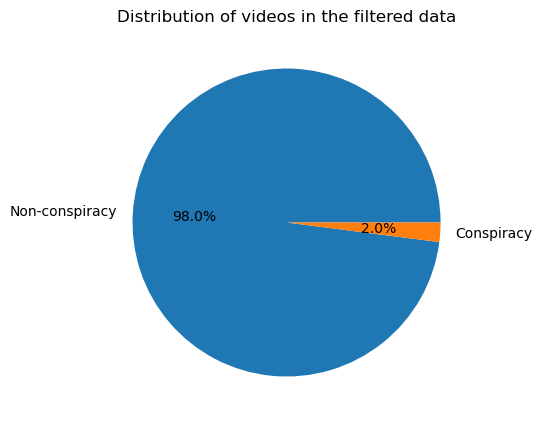

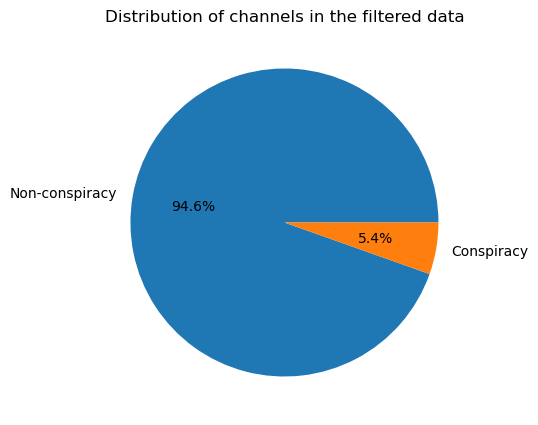

In [ ]:
# print(filtered_data.drop_duplicates(subset='display_id').shape())
all_videos = len(df_video['display_id'].unique())
filtered_videos = len(filtered_data['display_id'].unique())
all_channels = len(df_video['channel_id'].unique())
filtered_channels = len(filtered_data['channel_id'].unique())
print(f"all videos: {len(df_video['display_id'].unique())}")
print(f"filtered videos: {len(filtered_data['display_id'].unique())}")
print(f"all channels: {len(df_video['channel_id'].unique())}")
print(f"filtered channels: {len(filtered_data['channel_id'].unique())}")

# Plot the number of videos and channels in the filtered data
plt.figure(figsize=(10, 5))
plt.pie([all_videos - filtered_videos, filtered_videos], labels=['Non-conspiracy', 'Conspiracy'], autopct='%1.1f%%')
plt.title('Distribution of videos in the filtered data')
plt.show()

plt.figure(figsize=(10, 5))
plt.pie([all_channels - filtered_channels, filtered_channels], labels=['Non-conspiracy', 'Conspiracy'], autopct='%1.1f%%')
plt.title('Distribution of channels in the filtered data')
plt.show()

categories
News & Politics          5287
People & Blogs           1848
Entertainment             779
Comedy                    370
Education                 321
Nonprofits & Activism     290
Science & Technology       62
Film & Animation           60
Music                      18
Autos & Vehicles           16
Gaming                     13
Travel & Events             8
Howto & Style               6
Sports                      6
Name: count, dtype: int64


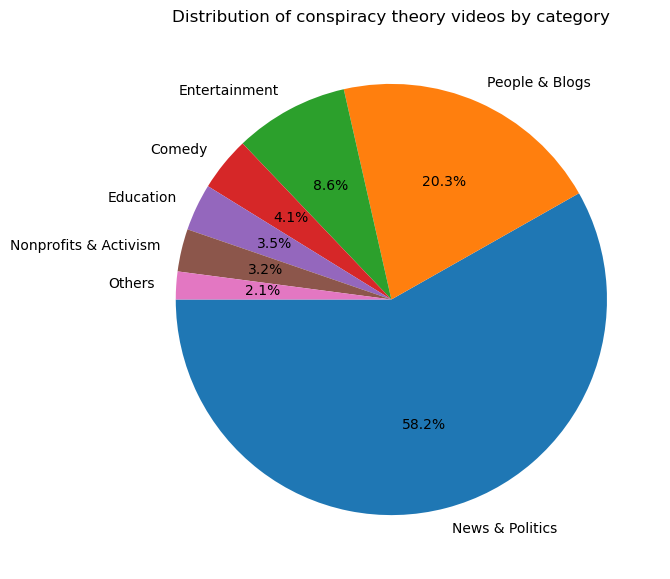

In [6]:
# Count the number of videos in each category
category_counts = filtered_data.drop_duplicates(subset='display_id')['categories'].value_counts()
print(category_counts)

# Plot the distribution of conspiracy theory videos by category
threshold = 0.02  # 2%
other_count = category_counts[category_counts / category_counts.sum() < threshold].sum()
main_categories = category_counts[category_counts / category_counts.sum() >= threshold]
main_categories['Others'] = other_count

# Plot the distribution of conspiracy theory videos by category
plt.figure(figsize=(10, 7))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=180)
plt.title('Distribution of conspiracy theory videos by category')
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [ ]:
# Load the Time Series Data from https://zenodo.org/records/4650046
df_ts = pd.read_csv("./df_timeseries_en.tsv.gz", compression="infer", sep="\t")
# df_sb_f["datetime"] = pd.to_datetime(df_sb_f["datetime"])
print(df_ts.head())

                    channel            category             datetime  \
0  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-03 00:00:00   
1  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-10 00:00:00   
2  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-17 00:00:00   
3  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-24 00:00:00   
4  UCBJuEqXfXTdcPSbGO9qqn1g  Film and Animation  2017-07-31 00:00:00   

          views    delta_views         subs  delta_subs  videos  delta_videos  \
0  2.024946e+05       0.000000   650.222222    0.000000       5             0   
1  3.940857e+05  191591.111111  1046.000000  395.777778       6             1   
2  8.353938e+05  441308.083333  1501.500000  455.500000       6             0   
3  1.104577e+06  269183.250000  1750.000000  248.500000       6             0   
4  1.284406e+06  179828.600000  2008.300000  258.300000       6             0   

   activity  
0         3  
1         1  
2         1  
3         0  
4         

In [38]:
print(df_ts.columns)

Index(['channel', 'category', 'datetime', 'views', 'delta_views', 'subs',
       'delta_subs', 'videos', 'delta_videos', 'activity'],
      dtype='object')


In [19]:
# Filter the time series data to include only the channels that have conspiracy theory videos
channels = filtered_data["channel_id"].unique()
channels_ts = df_ts[df_ts["channel"].isin(channels)].copy()

# Set the datetime column as the index
def adjust_date(dt):
    if dt.hour == 23:
        return dt + pd.Timedelta(days=1)
    else:
        return dt
channels_ts["datetime"] = pd.to_datetime(channels_ts["datetime"])
channels_ts["datetime"] = channels_ts["datetime"].apply(adjust_date).dt.date
channels_ts.set_index("datetime", inplace=True, drop=True)
channels_ts.index = pd.to_datetime(channels_ts.index)

print(channels_ts.shape)
print(channels_ts.head())

(113772, 9)
                             channel         category         views  \
datetime                                                              
2016-05-30  UCB2aea_wLJJaklTOplAC82A  News & Politics  3.653522e+07   
2016-06-06  UCB2aea_wLJJaklTOplAC82A  News & Politics  3.663792e+07   
2016-06-13  UCB2aea_wLJJaklTOplAC82A  News & Politics  3.670635e+07   
2016-06-20  UCB2aea_wLJJaklTOplAC82A  News & Politics  3.673342e+07   
2016-06-27  UCB2aea_wLJJaklTOplAC82A  News & Politics  3.683542e+07   

              delta_views          subs  delta_subs  videos  delta_videos  \
datetime                                                                    
2016-05-30   29341.555556  22596.333333    0.000000    3666             0   
2016-06-06  102695.444444  22678.000000   81.666667    3671             5   
2016-06-13   68437.250000  22727.875000   49.875000    3690            19   
2016-06-20   27070.250000  22811.500000   83.625000    3694             4   
2016-06-27  101993.875000  2

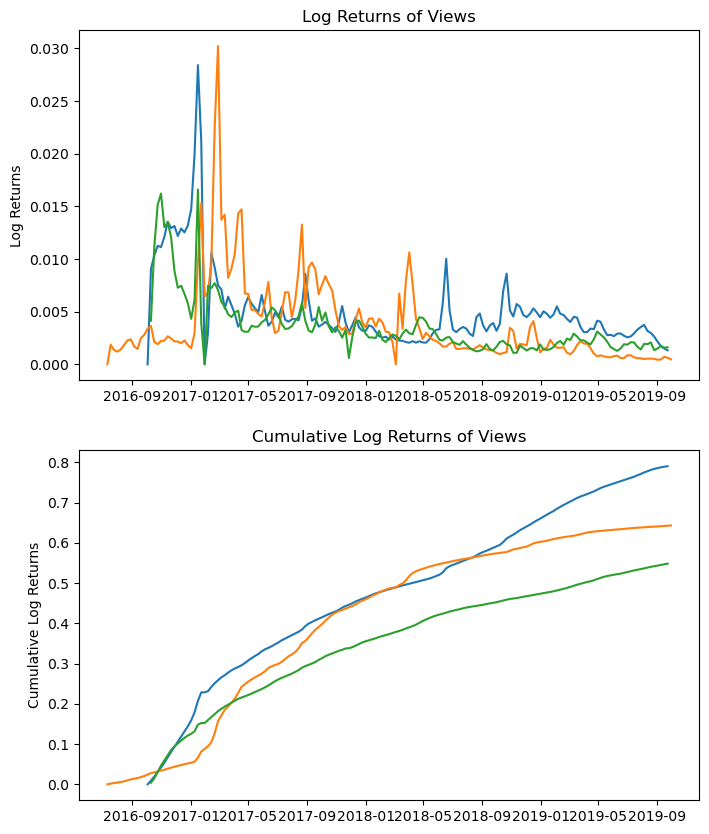

In [97]:
df = channels_ts.copy()

fig, ax = plt.subplots(2,1, figsize=(8, 10))

samples = df['channel'].unique()

for channel in np.random.choice(samples, size=3, replace=False):
    channel_data = df[df['channel'] == channel].copy()
    channel_data['log_returns'] = np.log10(channel_data['views'] / (channel_data['views'] - channel_data['delta_views']))
    channel_data['cumulative_log_returns'] = channel_data['log_returns'].cumsum()
    ax[0].plot(channel_data.index, channel_data['log_returns'], label=channel)
    ax[1].plot(channel_data.index, channel_data['cumulative_log_returns'], label=channel)

ax[0].set_title('Log Returns of Views')
ax[0].set_ylabel('Log Returns')

ax[1].set_title('Cumulative Log Returns of Views')
ax[1].set_ylabel('Cumulative Log Returns')

plt.show()

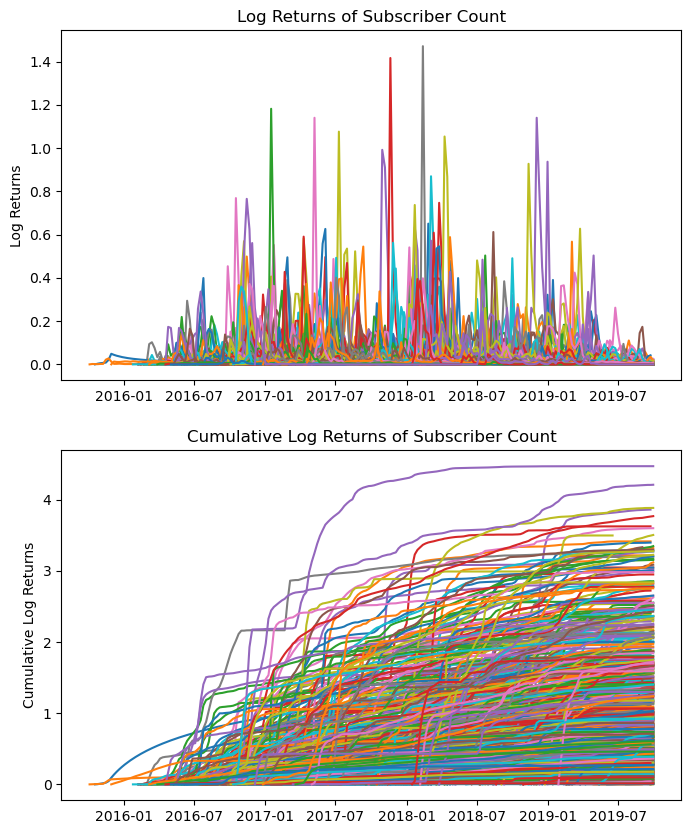

In [87]:
df = channels_ts.copy()

fig, ax = plt.subplots(2,1, figsize=(8, 10))

for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel].copy()
    channel_data['log_returns'] = np.log10(channel_data['subs'] / (channel_data['subs'] - channel_data['delta_subs']))
    channel_data['cumulative_log_returns'] = channel_data['log_returns'].cumsum()
    ax[0].plot(channel_data.index, channel_data['log_returns'], label=channel)
    ax[1].plot(channel_data.index, channel_data['cumulative_log_returns'], label=channel)

ax[0].set_title('Log Returns of Subscriber Count')
ax[0].set_ylabel('Log Returns')

ax[1].set_title('Cumulative Log Returns of Subscriber Count')
ax[1].set_ylabel('Cumulative Log Returns')

plt.show()

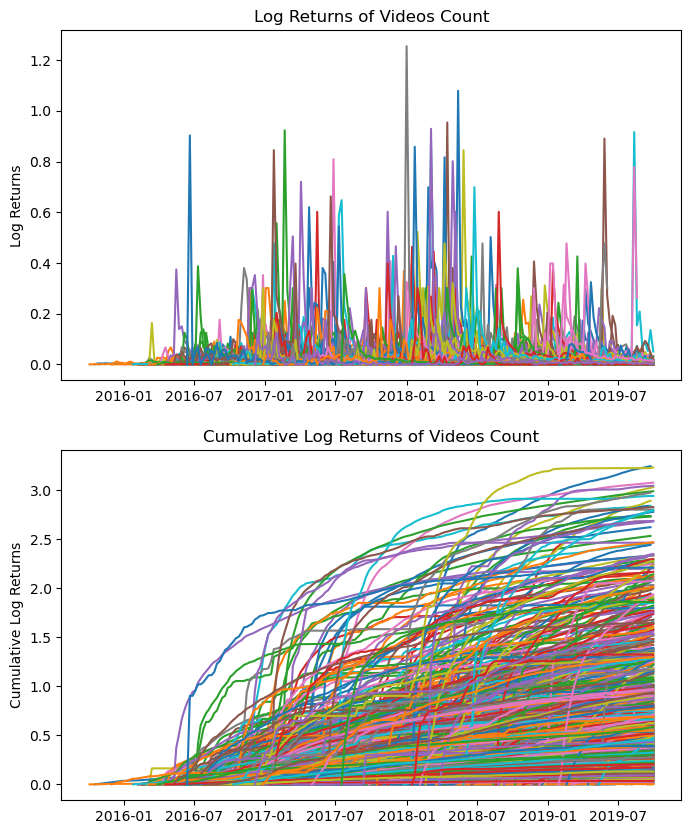

In [88]:
df = channels_ts.copy()

fig, ax = plt.subplots(2,1, figsize=(8, 10))

for channel in df['channel'].unique():
    channel_data = df[df['channel'] == channel].copy()
    channel_data['log_returns'] = np.log10(channel_data['videos'] / (channel_data['videos'] - channel_data['delta_videos']))
    channel_data['cumulative_log_returns'] = channel_data['log_returns'].cumsum()
    ax[0].plot(channel_data.index, channel_data['log_returns'], label=channel)
    ax[1].plot(channel_data.index, channel_data['cumulative_log_returns'], label=channel)

ax[0].set_title('Log Returns of Videos Count')
ax[0].set_ylabel('Log Returns')

ax[1].set_title('Cumulative Log Returns of Videos Count')
ax[1].set_ylabel('Cumulative Log Returns')

plt.show()